In [226]:
import pandas as pd
import numpy as np
import os
import torch
from torch.utils.data import Dataset,DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch.nn as nn
import torchtext
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import torch.optim as optim
import glob
import re
from sklearn.model_selection import train_test_split
import wandb
from sklearn.metrics import confusion_matrix
import seaborn as sns
from transformers import AutoModelForSequenceClassification
from collections import Counter

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from transformers import BertTokenizer, BertModel, DistilBertTokenizer, DistilBertModel
import transformers

In [2]:
# Constants
if not torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

EPOCHS = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 32

# Wandb thing
config={

    "learning_rate": LEARNING_RATE,
    "epochs": EPOCHS,
    "batch_size" : BATCH_SIZE,
}
# wandb.login()
# 
# wandb.init(project="FinalProjectSYDE599",config=config)

In [3]:
# Directories of the dataset 
train_original_directory = os.path.join("Data","Original_data","train_essays.csv")
test_original_directory = os.path.join("Data","Original_data","test_essays.csv")
train_original_prompts_directory = os.path.join("Data","Original_data","train_prompts.csv")

In [4]:
train_original_df = pd.read_csv(train_original_directory)
test_original_df = pd.read_csv(test_original_directory)
train_original_prompts_df = pd.read_csv(train_original_prompts_directory)

# Goals

In [5]:
# generated -> 0 means written by humans 
train_original_df.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [6]:
# Data Cleaning should be independent from the dataLoader (Usefull if we plan to use machine learning model as well
# Embedding should be injected into the dataloader class (Makes embedding indepent from the dataloading part 
# At the moment we don't care about the prompt text but might be usefull in future processing 

# Data Aggregation

In [7]:
class CreateDataset:
    """
    This class is just to clean the dataset and the output of this class should be a cleaned dataset
    """
    def __init__(self,values:list = None):
        self.__paths : list[str] = []
        
        if values:
            self.__paths = [*values]
        
    @property
    def paths(self):
        return self.__paths
    
    @paths.setter
    def paths(self,value):
        self.paths.append(value)
        
    def clean(self):
        final_df = None
        with tqdm(total=len(self.paths), desc="Processing CSV files") as pbar:
            for path in self.paths:
                temp_df = pd.read_csv(path)
                name = path.split('/')[-2]
                # if(name == "Original_data" or name == "llm-generated-essays"):
                #     temp_df = self.cleanOriginal(temp_df)
                # elif name == "daigt-external-dataset":
                #     temp_df = self.createGenerated(temp_df)
                # # elif name == "daigt-data-llama-70b-and-falcon180b":
                # #     temp_df = self.filter_text(temp_df)
                # elif name == "daigt-proper-train-dataset":
                #     temp_df = self.filter_daigt_proper(temp_df)
                if name == "daigt-v2-train-dataset":
                    temp_df = self.filter_daigt_proper(temp_df)
                    
                else:
                    continue
                    
        
                if final_df is None:
                    final_df = temp_df
                else:
                    final_df = pd.concat([final_df, temp_df])
        
                pbar.update(1)
                pbar.set_description(f"Processing: {path.split()[-1]}")
        return final_df
    
        
            
    def cleanOriginal(self,temp_df):
        return temp_df[["text","generated"]]

    def filter_daigt_proper(self,temp_df):
        temp_df["generated"] = temp_df["label"]
        return temp_df[["text","generated"]]

    def createGenerated(self,temp_df):
        temp_df["generated"] = 1
        return temp_df[["text","generated"]]

    def filter_text(self,temp_df):
        if "generated_text" in list(temp_df.columns):
            temp_df["text"] = temp_df["generated_text"]
        temp_df["generated"] = 1
        return temp_df[['text','generated']]

In [8]:
# get all the csv files
search_pattern = os.path.join("Data", '**', '*.csv')
csv_paths = glob.glob(search_pattern, recursive=True)
# Remove the test file 
csv_paths.remove(test_original_directory)
csv_paths.remove(train_original_prompts_directory)
csv_paths.remove(os.path.join("Data","Original_data","sample_submission.csv"))


In [9]:
customDataset = CreateDataset(csv_paths)

In [10]:
train_complete_df = customDataset.clean()

Processing: Data/daigt-v2-train-dataset/train_v2_drcat_02.csv:   5%|▍         | 1/22 [00:10<03:38, 10.41s/it]


In [11]:
train_complete_df["generated"].value_counts()

generated
0    27371
1    17497
Name: count, dtype: int64

In [12]:
def split_train_by_senctence_window(df,is_sentence = True,k_sentences = 0 , window_size_= 100 , stride = 50):
    if is_sentence:
        # based on the sentences 
        k = 0
        temp_df = df["text"].apply(lambda x: re.findall(r'[^.!?]+[.!?]', x))
        temp_df = temp_df.apply(lambda x : [s.replace("\n","").strip() for s in x if s != ""])
        # combine the sentences 
        if k != 0:
            temp_df = temp_df.apply(lambda x : [" ".join(x[i:i+1+k]) for i in range(len(x)-k)])
        columns = list(df.columns)
        columns.remove('text')
        temp_df = pd.concat([temp_df,df[columns]],axis = 1)
        temp_df = temp_df.explode("text")
        temp_df.dropna(inplace = True)
        temp_df.reset_index(inplace = True,drop = True)
    else:
        # based on the window
        window_size = 100
        stride = 50
        temp_df = df["text"].apply(lambda x : [x[i:i+1+window_size] for i in range(0,len(x)-window_size,stride)])
        columns = list(df.columns)
        columns.remove('text')
        temp_df = pd.concat([temp_df,df[columns]],axis = 1)
        temp_df = temp_df.explode("text")
        temp_df.dropna(inplace = True)
        temp_df.reset_index(inplace = True,drop = True)
    return temp_df

In [13]:
# Split the dataset based on Sentences 
train_complete_df = split_train_by_senctence_window(train_complete_df,k_sentences=3)

In [14]:
# Split the dataset based on the counts of 0 and 1
stratify_column = 'generated'
train_complete_df, validation_complete_df = train_test_split(train_complete_df, test_size=0.2, stratify=train_complete_df[stratify_column], random_state=42)

In [15]:
train_complete_df

,text,generated
616456,"It can make you happier, help you overcome obs...",1
894372,"Fourth, the Electoral College can lead to a cr...",1
759773,Laws and protocols must clarify responsibiliti...,1
478335,So these kids are now not only being graded on...,0
64054,"Robert Duffer states, ""Congestion was down six...",0
...,...,...
505214,Think of it like a tree; the trunk is the advi...,0
753456,These donations will be used to cover the cost...,1
614868,"Hey, I'm like, totally stoked to be writing th...",1
646950,"For example, some students may struggle with t...",1


# Exploratory data Analysis

In [12]:
all_words_humans = []
all_words_ai = []

# Use tqdm to add a progress bar
for index,row in tqdm(train_complete_df.iterrows(), desc='Processing texts', unit='text'):
    final_text = row['text']
    words = str(final_text).split()
    if row['generated'] == 0:
        all_words_humans.extend(words)
    else:
        all_words_ai.extend(words)

Processing texts: 44868text [00:01, 31734.92text/s]


In [13]:
counter_humans = Counter(all_words_humans)
counter_ai = Counter(all_words_ai)

In [14]:
len(counter_humans)

153847

In [15]:
len(counter_ai)

59173

In [16]:
# comman words 
# Get common words and their frequencies
common_words = counter_humans & counter_ai

# Print common words and their frequencies
print("Common words and their frequencies:")
print(len(common_words))


Common words and their frequencies:
35004


In [17]:
# Print most common words in counter_humans
print("Most common words in counter_humans:")
print(counter_humans.most_common(10))

# Print most common words in counter_ai
print("\nMost common words in counter_ai:")
print(counter_ai.most_common(10))


Most common words in counter_humans:
[('the', 488916), ('to', 410350), ('and', 268688), ('a', 268355), ('of', 219057), ('that', 176860), ('is', 168992), ('in', 158714), ('be', 130641), ('you', 127159)]

Most common words in counter_ai:
[('to', 210391), ('and', 207318), ('the', 205134), ('a', 142997), ('of', 132836), ('in', 85734), ('can', 81521), ('that', 77453), ('is', 74384), ('for', 58432)]


In [18]:
# Calculate the ratio of frequencies for each word
word_ratios = {word: counter_humans[word] / counter_ai[word] for word in counter_humans if word in counter_humans and word in counter_ai}

# Create a Counter from the dictionary
word_ratios_counter = Counter(word_ratios)

# Print top 10 word ratios
print("Top 10 Word Frequencies Ratio:")
print(word_ratios_counter.most_common(10))


Top 10 Word Frequencies Ratio:
[('didnt', 911.0), ('doesnt', 850.0), ('TEACHER_NAME,', 660.0), (',', 531.8), ('97', 494.0), ('?', 478.0), ("i'm", 440.0), ('thats', 395.6), ('sharper', 385.0), ('Say', 382.0)]


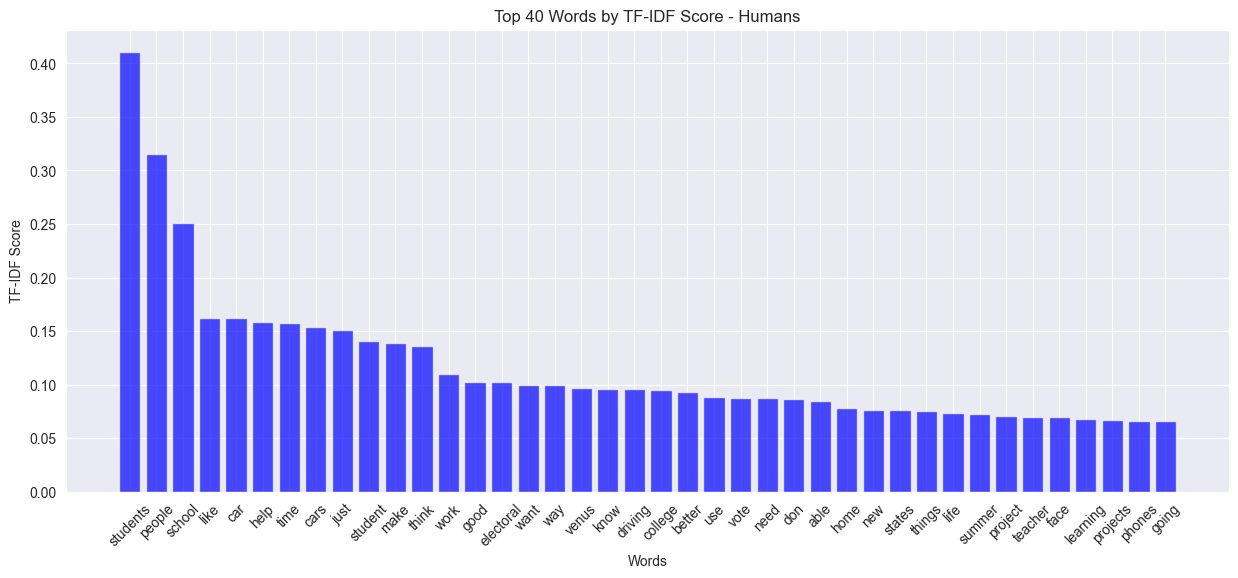

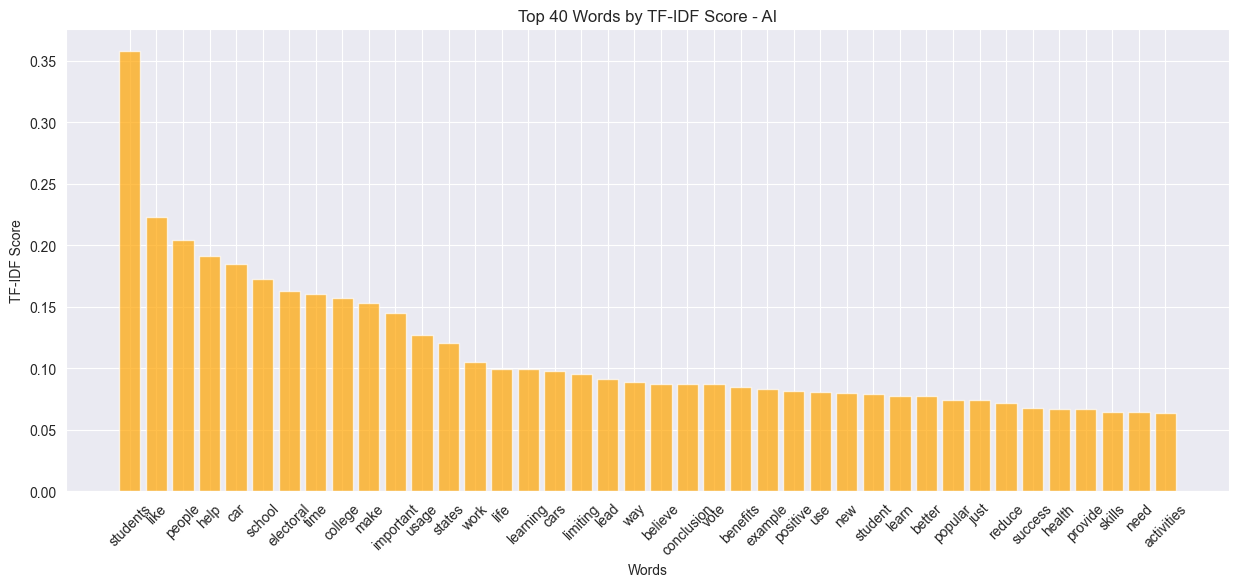

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have lists of text for humans and AI
texts_humans = [" ".join(all_words_humans)]  # Assuming you have a list of words for humans
texts_ai = [" ".join(all_words_ai)]  # Assuming you have a list of words for AI

# Create separate DataFrames for humans and AI
df_humans = pd.DataFrame({'text': texts_humans})
df_ai = pd.DataFrame({'text': texts_ai})

# Create separate TF-IDF vectorizers for humans and AI
vectorizer_humans = TfidfVectorizer(stop_words='english')
vectorizer_ai = TfidfVectorizer(stop_words='english')

# Fit and transform the data for humans
tfidf_matrix_humans = vectorizer_humans.fit_transform(df_humans['text'])

# Fit and transform the data for AI
tfidf_matrix_ai = vectorizer_ai.fit_transform(df_ai['text'])

# Get feature names (words) for humans
feature_names_humans = vectorizer_humans.get_feature_names_out()

# Get feature names (words) for AI
feature_names_ai = vectorizer_ai.get_feature_names_out()

# Sum the TF-IDF scores for each feature (word) across humans
tfidf_sum_humans = tfidf_matrix_humans.sum(axis=0).A1

# Sum the TF-IDF scores for each feature (word) across AI
tfidf_sum_ai = tfidf_matrix_ai.sum(axis=0).A1

# Create separate DataFrames with words and their corresponding TF-IDF scores for humans and AI
tfidf_df_humans = pd.DataFrame({'word': feature_names_humans, 'tfidf': tfidf_sum_humans})
tfidf_df_ai = pd.DataFrame({'word': feature_names_ai, 'tfidf': tfidf_sum_ai})

# Sort the DataFrames by TF-IDF score in descending order
tfidf_df_humans = tfidf_df_humans.sort_values(by='tfidf', ascending=False)
tfidf_df_ai = tfidf_df_ai.sort_values(by='tfidf', ascending=False)

# Plot the top N words by TF-IDF score for humans
top_n = 40  # Adjust as needed
plt.figure(figsize=(15, 6))
plt.bar(tfidf_df_humans['word'][:top_n], tfidf_df_humans['tfidf'][:top_n], color='blue', alpha=0.7)
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.title(f'Top {top_n} Words by TF-IDF Score - Humans')
plt.xticks(rotation=45)
plt.show()

# Plot the top N words by TF-IDF score for AI
plt.figure(figsize=(15, 6))
plt.bar(tfidf_df_ai['word'][:top_n], tfidf_df_ai['tfidf'][:top_n], color='orange', alpha=0.7)
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.title(f'Top {top_n} Words by TF-IDF Score - AI')
plt.xticks(rotation=45)
plt.show()


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import nltk

# nltk.download('punkt')
# nltk.download('stopwords')
nltk.download('wordnet')


# Assuming you have lists of text for humans and AI
texts_humans = [" ".join(all_words_humans)]  # Assuming you have a list of words for humans
texts_ai = [" ".join(all_words_ai)]  # Assuming you have a list of words for AI

# Define a lemmatizer
lemmatizer = WordNetLemmatizer()


# Define a function for text preprocessing
def preprocess_text(text):
    # Tokenize the text
    words = word_tokenize(text)

    # Remove stop words
    words = [word for word in words if word.lower() not in stopwords.words('english')]

    # Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join the processed words back into a string
    processed_text = " ".join(words)

    return processed_text

# Preprocess text for humans
preprocessed_texts_humans = [preprocess_text(text) for text in texts_humans]

# Preprocess text for AI
preprocessed_texts_ai = [preprocess_text(text) for text in texts_ai]

# Create separate DataFrames for humans and AI
df_humans = pd.DataFrame({'text': preprocessed_texts_humans})
df_ai = pd.DataFrame({'text': preprocessed_texts_ai})

# Create separate TF-IDF vectorizers for humans and AI
vectorizer_humans = TfidfVectorizer()
vectorizer_ai = TfidfVectorizer()

# Fit and transform the data for humans
tfidf_matrix_humans = vectorizer_humans.fit_transform(df_humans['text'])

# Fit and transform the data for AI
tfidf_matrix_ai = vectorizer_ai.fit_transform(df_ai['text'])

# Get feature names (words) for humans
feature_names_humans = vectorizer_humans.get_feature_names_out()

# Get feature names (words) for AI
feature_names_ai = vectorizer_ai.get_feature_names_out()

# Sum the TF-IDF scores for each feature (word) across humans
tfidf_sum_humans = tfidf_matrix_humans.sum(axis=0).A1

# Sum the TF-IDF scores for each feature (word) across AI
tfidf_sum_ai = tfidf_matrix_ai.sum(axis=0).A1

# Create separate DataFrames with words and their corresponding TF-IDF scores for humans and AI
tfidf_df_humans = pd.DataFrame({'word': feature_names_humans, 'tfidf': tfidf_sum_humans})
tfidf_df_ai = pd.DataFrame({'word': feature_names_ai, 'tfidf': tfidf_sum_ai})

# Sort the DataFrames by TF-IDF score in descending order
tfidf_df_humans = tfidf_df_humans.sort_values(by='tfidf', ascending=False)
tfidf_df_ai = tfidf_df_ai.sort_values(by='tfidf', ascending=False)


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kirtankanani/nltk_data...


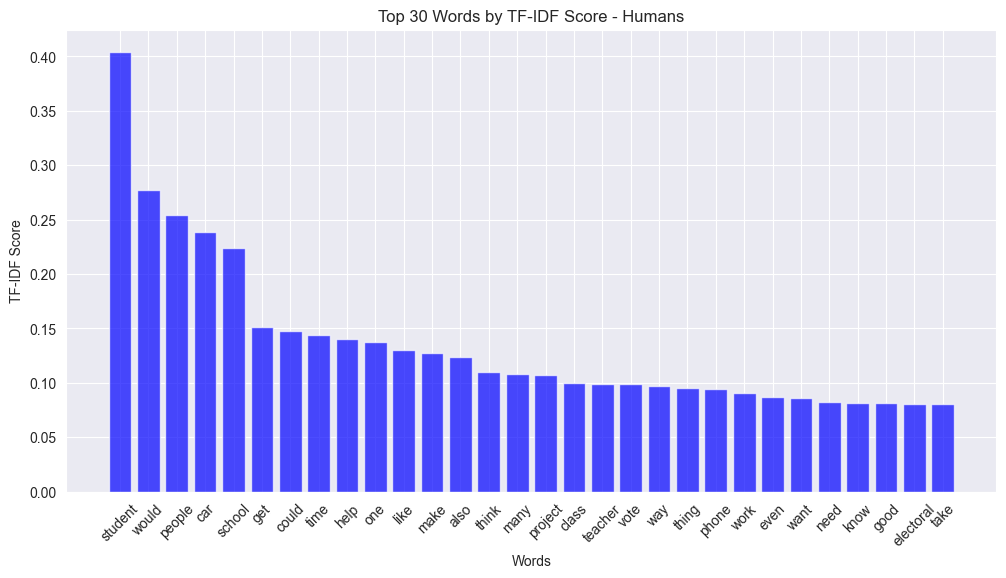

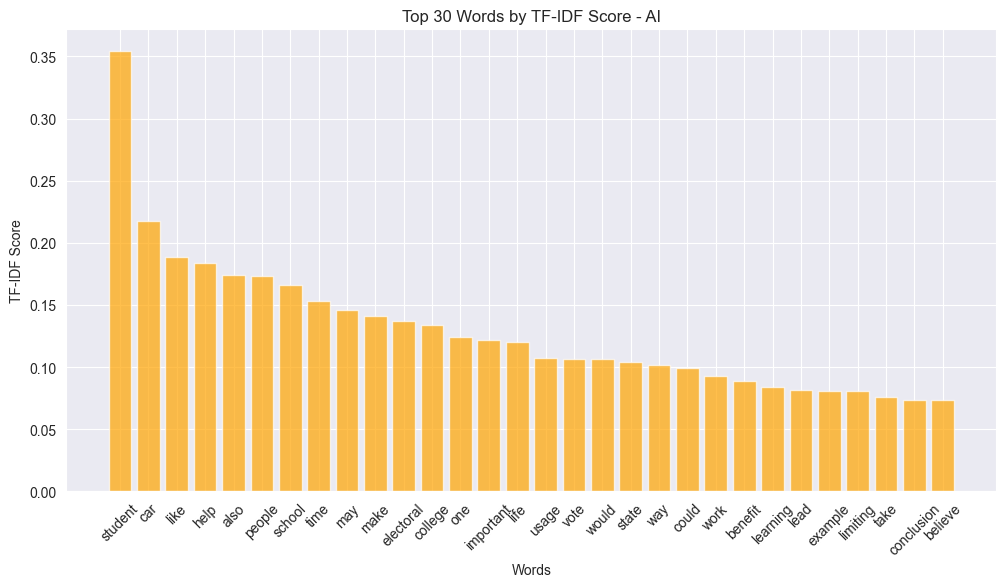

In [35]:
# Plot the top N words by TF-IDF score for humans
top_n = 30  # Adjust as needed
plt.figure(figsize=(12, 6))
plt.bar(tfidf_df_humans['word'][:top_n], tfidf_df_humans['tfidf'][:top_n], color='blue', alpha=0.7)
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.title(f'Top {top_n} Words by TF-IDF Score - Humans')
plt.xticks(rotation=45)
plt.show()

# Plot the top N words by TF-IDF score for AI
plt.figure(figsize=(12, 6))
plt.bar(tfidf_df_ai['word'][:top_n], tfidf_df_ai['tfidf'][:top_n], color='orange', alpha=0.7)
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.title(f'Top {top_n} Words by TF-IDF Score - AI')
plt.xticks(rotation=45)
plt.show()


# Data Loading

In [200]:
class Vocab:
    def __init__(self,unknown_token):
        self.word_to_index = {}
        self.index_to_word = {}
        self._index = 0
        self.unknown_token = unknown_token
        self.insert_token(self.unknown_token)
        self.unknown_token_index = 0
    
    def increment_index(self): 
        self._index += 1
        
    def insert_token(self,token):
        self.word_to_index[token] = self._index
        self.index_to_word[self._index] = token
        self._index += 1
        
    def getIndex(self):
        return self._index
        
    def __getitem__(self, item):
        if item in self.word_to_index:
            return self.word_to_index[item]
        return self.unknown_token_index

In [201]:
class CustomTokenizer:
    
    def __init__(self,df,unknown_token = "<UNK>",start_token = "<START>",end_token = "<END>",pad_token = "<PAD>",threshold = 0.0 ):
        self.df = df
        self.unknown_token = unknown_token
        self.start_token = start_token
        self.end_token = end_token
        self.lemmatizer = WordNetLemmatizer()
        self.threshold = threshold
        self.pad_token = pad_token
        
    def create_vocab(self):
        self.vocab = Vocab(unknown_token = self.unknown_token)
        
        # insert all the predefined tokens 
        self.vocab.insert_token(self.pad_token)
        self.vocab.insert_token(self.start_token)
        self.vocab.insert_token(self.end_token)
        
        
        all_words_counter = self.df["text"].apply(lambda text: text.split()).explode().tolist()
        all_words_counter = Counter(all_words_counter)
        for key, value in tqdm(all_words_counter.items(), desc="Building Vocabulary", unit="word"):
            self.vocab.insert_token(key)
            
    def convert_tokens_to_ids(self,token):
        return self.vocab[token]
            
    
    def __call__(self,text):
        # Preprocess remove all the stop words and also lamentize all the words 
        words = self.__class__.cleanText(text,self.lemmatizer)
        vectorizered_version = [self.vocab[word] for word in words]
        vectorizered_version = [self.vocab[self.start_token]] + vectorizered_version + [self.vocab[self.end_token]]
        return {"input_ids" : vectorizered_version,
                "attention_mask" : list(np.ones(len(vectorizered_version)))}
        
    @staticmethod
    def cleanText(text,lemmatizer):
        words = word_tokenize(text)
        words = [word for word in words if word.lower() not in stopwords.words('english')]
        words = [lemmatizer.lemmatize(word) for word in words]
        return words
    
    def vocab_size(self):
        return self.vocab.getIndex()

    def clean_df(self):
        def preprocess_text(row):
            text = row["text"]
            words = self.__class__.cleanText(text,self.lemmatizer)
            processed_text = " ".join(words)
            row["text"] = processed_text
            return row
        self.df = self.df.progress_apply(preprocess_text, axis=1)


In [202]:
customTokenizer = CustomTokenizer(train_complete_df[:100])
customTokenizer.clean_df()

100%|██████████| 100/100 [00:00<00:00, 895.85it/s]


In [203]:
customTokenizer.create_vocab()

Building Vocabulary: 100%|██████████| 631/631 [00:00<00:00, 3316548.65word/s]


In [204]:
customTokenizer.vocab_size()

635

In [205]:
# Using pretrained model tokenizer 
model_name = "microsoft/deberta-v3-xsmall"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/opt/miniconda3/envs/kaggle/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [206]:
len(tokenizer.get_vocab())

128001

In [207]:
# Create a DataLoader class 
class DetectionDataset(Dataset):

    def __init__(self,df,Tokenizer = None,train = True,max_length = 100,preTrained = False):
        self.tokenizer = Tokenizer
        self.train = train
        self.df = df
        self.max_length = max_length
        self.padded_token = 0 if self.tokenizer is None else self.tokenizer.convert_tokens_to_ids(self.tokenizer.pad_token)
        self.preTrained = preTrained
        self._data = df
        self._data.column_names = df.columns

    def __len__(self):
        return len(self.df)

    def __getitem__(self, item):
        """
        :return: text containing the indexes in numpy array / list
        """

        if self.train:
            if self.tokenizer is None:
                return {"text" : self.df.iloc[item]["text"],"score" : self.df.iloc[item]["generated"]}
            else:
                vectorized_text,mask = self.vectorize(self.df.iloc[item]["text"])
                return {"text" : vectorized_text,"score" : self.df.iloc[item]["generated"],
                        "mask" : mask}
        else:
            if self.tokenizer is None:
                return {"text" : self.df.iloc[item]["text"]}
            else:
                vectorized_text,mask = self.vectorize(self.df.iloc[item]["text"])
                return {"text" : vectorized_text,"mask": mask}


    def data_collator(self, batch):
        max_length = max([len(item['input_ids']) for item in batch])
        texts = [self.pad(item['input_ids'],max_length) for item in batch]
        scores = [item['labels'] for item in batch]
        return {'text': torch.LongTensor(texts),
                'score': torch.tensor(scores, dtype=torch.float32)}


    def pad(self,vector,length):
        result = np.ones(length) * self.padded_token
        result[:len(vector)] = vector
        return result

    def commonCollate(self,batch):
        max_length = max([len(item['text']) for item in batch])
        texts = [self.pad(item['text'],max_length) for item in batch]
        masks = [self.pad(item['mask'],max_length) for item in batch]
        return texts,masks


    def collate(self,batch):
        texts,masks = self.commonCollate(batch)
        scores = [item['score'] for item in batch]
        return {'text': torch.LongTensor(texts),
                'score': torch.tensor(scores, dtype=torch.float32),
                'mask' : torch.tensor(masks,dtype=torch.float32)}

    def test_collate(self,batch):
        texts,masks = self.commonCollate(batch)
        return {'text' : torch.LongTensor(texts),
                'mask' : torch.tensor(masks,dtype=torch.float32)}

    def vectorize(self,text):
        encoded = self.tokenizer(text)
        return encoded["input_ids"],encoded["attention_mask"]

In [208]:
train_detectionDataset = DetectionDataset(train_complete_df,customTokenizer)
validation_detectionDataset = DetectionDataset(validation_complete_df,customTokenizer)
test_detectionDataset = DetectionDataset(test_original_df,customTokenizer, train = False)

In [209]:
train_dataloader = DataLoader(train_detectionDataset, batch_size=32, shuffle=True, collate_fn=train_detectionDataset.collate)
validation_dataloader = DataLoader(validation_detectionDataset, batch_size=32, shuffle=True, collate_fn=validation_detectionDataset.collate)
test_dataloader = DataLoader(test_detectionDataset, batch_size=len(test_detectionDataset), shuffle=False, collate_fn=test_detectionDataset.test_collate)

# Fine Tunining Pretrained Model

In [229]:
class TransformersModel(nn.Module):

    def __init__(self, bert_model, layer_size):
        super(TransformersModel, self).__init__()

        #         self.Model = DistilBertModel.from_pretrained(bert_model)
        self.Model = BertModel.from_pretrained(bert_model)
        self.ln1 = nn.Linear(768, layer_size)
        self.ln2 = nn.Linear(layer_size, 1)

    def forward(self, ids,mask):
        '''A forward pass of this network.
        Use `verbose=True` if you want to see output shape at each pass.'''

        text = self.Model(ids,mask)[0]
        out_ln1 = self.ln1(text)
        out_ln2 = self.ln2(out_ln1)
        out = out_ln2[:, 0, :]

        return out

# Model Training

In [230]:
# source : https://d2l.ai/chapter_attention-mechanisms-and-transformers/multihead-attention.html
class PositionalEncoding(nn.Module):  #@save
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=3000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In [231]:
class Transformer(nn.Module):
    def __init__(self,vocab_size,embedding_size,n_layers = 3,nhead = 5,dim_feedforward = 512,dropout = 0.5,activation = "gelu"):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,embedding_size)
        self.position_encoding = PositionalEncoding(embedding_size,dropout)
        self.Encoder = nn.TransformerEncoderLayer(
            d_model = embedding_size,
            nhead = nhead,
            dim_feedforward= dim_feedforward,
            dropout = dropout,
            activation = activation,
            batch_first= True,
            norm_first= True,
        )
        self.transformer_encoder = nn.TransformerEncoder(self.Encoder, num_layers=n_layers)

        self.output1 = nn.Linear(embedding_size,128,bias = True)
        self.output2 = nn.Linear(128,1,bias = True)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x,mask):
        x = self.embedding(x) # B x T X C
        x = self.position_encoding(x) # B x T x C with position information added
        x = self.transformer_encoder(x,src_key_padding_mask=mask)
        x = self.output1(x)
        x = self.output2(x)
        x = self.sigmoid(x)
        return x

In [232]:
model = Transformer(len(tokenizer.get_vocab()),300)

/opt/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [233]:
def train_batch(X,y,mask,model,loss_function,optimizer):
    """
    :return: (loss , accuracy)
    """
    model.train()
    predicitons = model(X,mask) # Batch * Time stamp * 1
    predicitons = torch.mean(predicitons,1).squeeze()
    batch_loss = loss_function(predicitons,y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    batch_loss_item = batch_loss * X.shape[0]
    return batch_loss_item.detach().cpu().item(),accuray(y,predicitons).detach().cpu().item()

class BestModelSaveCallback:
    def __init__(self, save_path):
        self.save_path = save_path
        self.best_accuracy = -1

    def __call__(self, accuracy,model):
        if accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            model.to(device = "cpu")
            torch.save(model.state_dict(), self.save_path)
            model.to(device=DEVICE)


@torch.no_grad()
def Inference(X,y,mask,model,loss_function):
    model.eval()
    predictions = model(X,mask)
    predictions = torch.mean(predictions,1).squeeze()
    loss = loss_function(predictions,y)
    accuracy = torch.sum((predictions >= 0.5).int() == y)
    return loss.detach().cpu().item() * X.shape[0],accuracy.detach().cpu().item()

def computeConfusionMatrix(model,validationLoader):
    model.eval()
    ground_truth,predictions = [],[]
    for batch in validationLoader:

        x,y,mask = batch["text"],batch["score"],batch["mask"]
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        mask = mask.to(DEVICE)
        prediction = model(x,mask)
        prediction = torch.mean(prediction,1).squeeze()
        prediction = (prediction >= 0.5).int()
        ground_truth.extend((y.detach().cpu().numpy().tolist()))
        predictions.extend((prediction.detach().cpu().numpy().tolist()))
        
        break

    return ground_truth,predictions


def Plot(model,validationLoader,path=""):

    ground_truth,predictions = computeConfusionMatrix(model,validationLoader)
    cm = confusion_matrix(ground_truth, predictions)
    labels = ["Humans","AI"]

    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    #     plt.savefig(os.path.join(path,"ConfusionMatrix.png"))
    # wandb.log({"Confusion Matrix": wandb.Image(plt)})


def train(train_loader,test_loader,model,loss_function,optimizer,best_model_callback):
    """
    :return: (plot nothing to return )
    """
    # wandb.watch(model,loss_function,log = "all",log_freq=500)
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    for epoch in range(EPOCHS):
        train_loss_epoch,train_accuracy_epoch = [],[]
        test_loss_epoch, test_accuracy_epoch = [],[]
        step_counter = epoch * len(train_loader.dataset)

        # Training loop with tqdm
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1} - Training') as train_batch_bar:
            for batch in train_loader:
                X = batch["text"].to(DEVICE)
                y = batch["score"].to(DEVICE)
                mask = batch["mask"].to(DEVICE)
                loss, accuracy = train_batch(X, y,mask, model, loss_function, optimizer)
                train_loss_epoch.append(loss)
                train_accuracy_epoch.append(accuracy)

                # wandb.log({"Training Batch Loss": loss / len(y)}, step=step_counter)
                # wandb.log({"Training Batch Accuracy": accuracy / len(y)}, step=step_counter)

                # Increment step counter
                step_counter += 1
                train_batch_bar.update(1)
                
                break


        step_counter = epoch * len(test_loader.dataset)



        # Testing loop with tqdm
        with tqdm(total=len(test_loader), desc=f'Epoch {epoch + 1} - Validation') as test_batch_bar:
            for batch in test_loader:
                X = batch["text"].to(DEVICE)
                y = batch["score"].to(DEVICE)
                mask = batch["mask"].to(DEVICE)
                loss, accuracy = Inference(X, y,mask, model, loss_function)
                test_loss_epoch.append(loss)
                test_accuracy_epoch.append(accuracy)

                # wandb.log({"Validation Batch Loss": loss / len(y)}, step=step_counter)
                # wandb.log({"Validation Batch Accuracy": accuracy / len(y)}, step=step_counter)

                step_counter += 1
                test_batch_bar.update(1)
                
                break
                
        
        break

        best_model_callback(np.sum(np.array(test_accuracy_epoch))/len(test_loader.dataset),model)

        train_losses.append(np.sum(np.array(train_loss_epoch)) / len(train_loader.dataset)  )
        train_accuracies.append(np.sum(np.array(train_accuracy_epoch)) / len(train_loader.dataset) )
        test_losses.append(np.sum(np.array(test_loss_epoch))/ len(test_loader.dataset) )
        test_accuracies.append(np.sum(np.array(test_accuracy_epoch)) / len(test_loader.dataset) )

        # epoch_bar.set_postfix(
        #     loss=f'{np.sum(np.array(train_loss_epoch)) / len(train_loader.dataset):.4f}',
        #     accuracy=f'{100 * np.sum(np.array(train_accuracy_epoch)) / len(train_loader.dataset):.2f}%'
        # )
        # epoch_bar.set_description(f'Epoch {epoch + 1}')
        # epoch_bar.update(1)


    plot(train_losses,train_accuracies,test_losses,test_accuracies)
    Plot(model,test_loader)

def plot(train_losses,train_accuracies,test_losses,test_accuracies):
    """
    :return:
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(train_losses, label='Train Loss', marker='o')
    axs[0].plot(test_losses, label='Test Loss', marker='o')
    axs[0].set_title('Training and Test Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(train_accuracies, label='Train Accuracy', marker='o')
    axs[1].plot(test_accuracies, label='Test Accuracy', marker='o')
    axs[1].set_title('Training and Test Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    fig.tight_layout()


    # Log the plot to WandB
    # wandb.log({"plot": wandb.Image(plt)})



def accuray(y_true,y_predictions):
    """
    :return: accuracy
    """
    final_predicitons = (y_predictions >= 0.5).int()
    total_accuracy = torch.sum(y_true == final_predicitons)
    return total_accuracy

In [234]:
# model = Transformer(len(tokenizer.get_vocab()),300).to(DEVICE)
model = TransformersModel("bert-base-uncased", layer_size=200)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-3)
best_model_callback = BestModelSaveCallback(save_path=os.path.join('best_model.pth'))

Epoch 1 - Validation:   0%|          | 1/5622 [00:00<40:45,  2.30it/s]


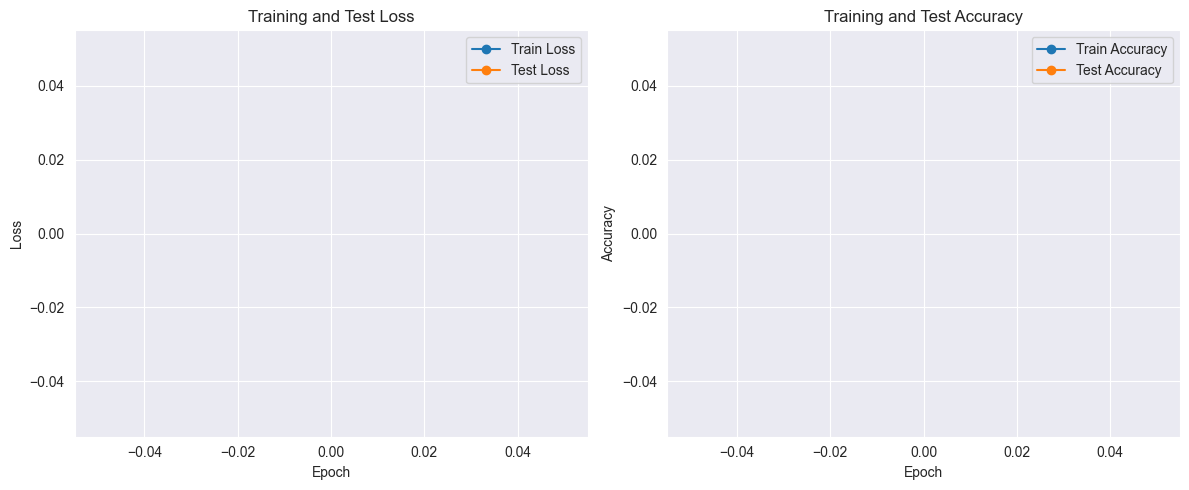

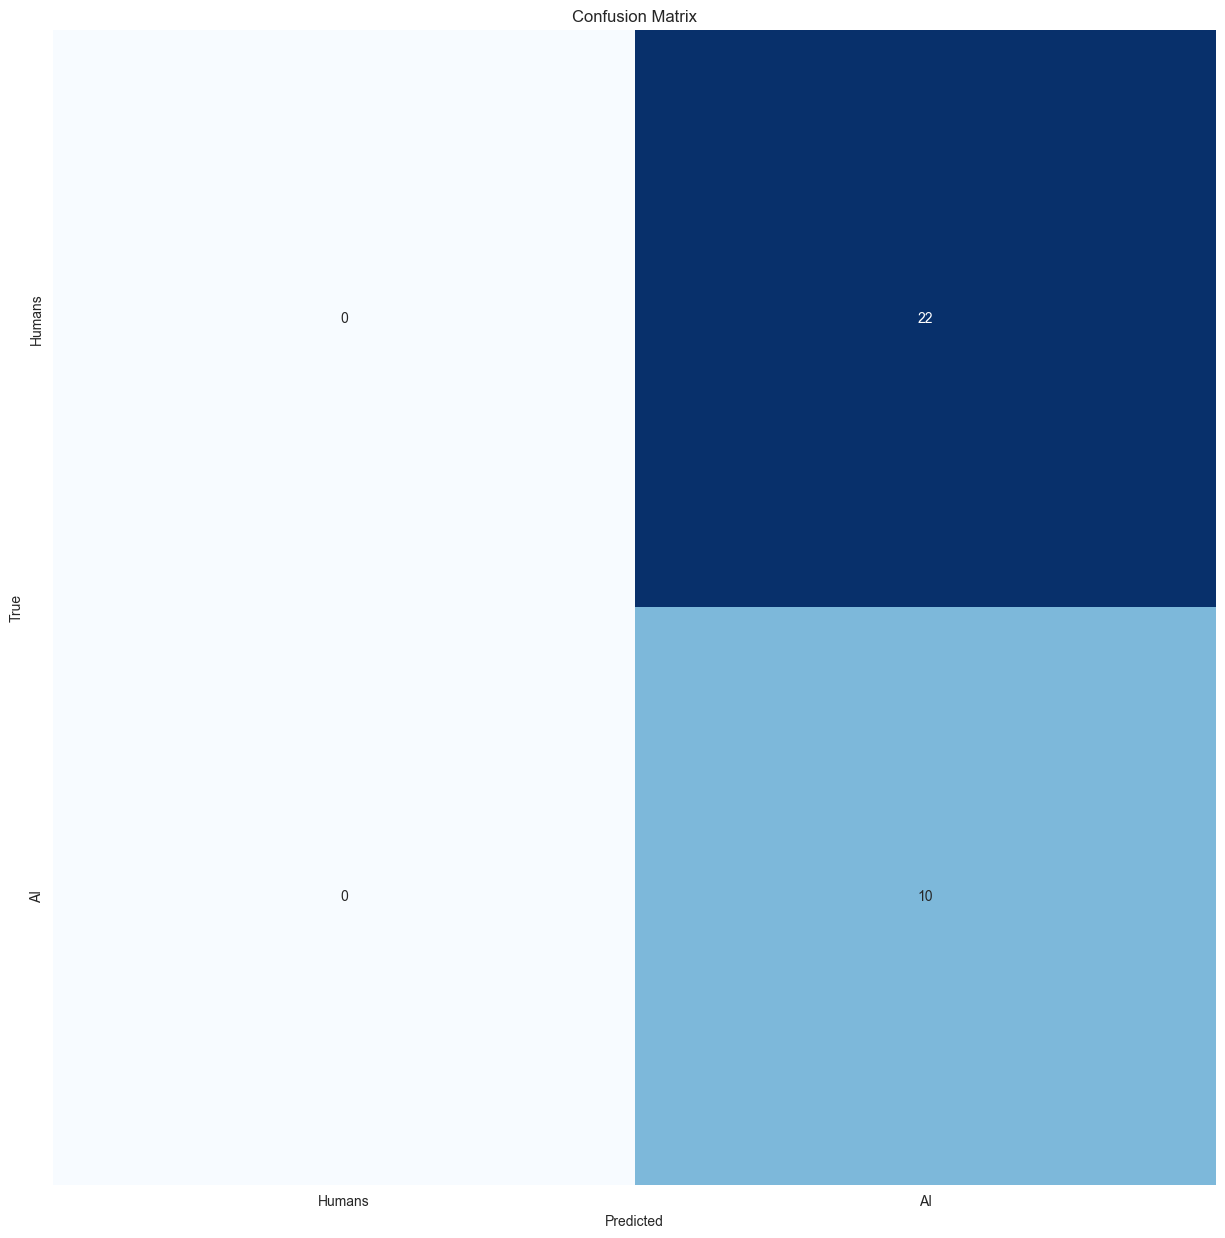

In [235]:
train(train_dataloader,validation_dataloader,model,loss_function,optimizer,best_model_callback)

In [236]:
#Prediction part
predictions = []
ids = []
for batch in test_dataloader:
    prediction = model(batch["text"])
    prediction = torch.mean(prediction,1)
    predictions.extend(prediction.squeeze().detach().numpy())
    ids.extend(batch["id"])
predictions = np.array(predictions)
ids = np.array(ids)
test_submission_df = pd.concat([pd.Series(predictions, name='Predictions'), pd.Series(ids, name='IDs')], axis=1)
test_submission_df = test_submission_df.groupby('IDs')['Predictions'].mean().reset_index()

TypeError: TransformersModel.forward() missing 1 required positional argument: 'mask'

In [ ]:
test_submission_df

In [70]:
wandb.finish()

Training Batch Accuracy,▁
Training Batch Loss,▁
Validation Batch Accuracy,▁
Validation Batch Loss,▁
Training Batch Accuracy,25
Training Batch Loss,19.94579
Validation Batch Accuracy,22
Validation Batch Loss,915.94238
